# Data wrangling : sparsify, use indices for labels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps

In [2]:
envs = pd.read_csv('training_environments.csv', index_col=0)
empo_names = [f'empo_{i}' for i in range(1, 4)]
empo_index_to_label = []

for empo in empo_names:
    empo_index_to_label.append([str(row) for row in envs.drop_duplicates(subset=empo)[empo]])
    
empo_label_to_index = {name : {label : i for i, label in enumerate(labels)} for name, labels in zip(empo_names, empo_index_to_label)}
empo_label_to_index

{'empo_1': {'Free-living': 0, 'Host-associated': 1},
 'empo_2': {'Non-saline': 0, 'Saline': 1, 'Animal': 2, 'Plant': 3},
 'empo_3': {'Water (non-saline)': 0,
  'Soil (non-saline)': 1,
  'Sediment (saline)': 2,
  'Animal surface': 3,
  'Surface (non-saline)': 4,
  'Animal distal gut': 5,
  'Animal corpus': 6,
  'Plant surface': 7,
  'Water (saline)': 8,
  'Animal secretion': 9,
  'Sediment (non-saline)': 10,
  'Plant rhizosphere': 11,
  'Plant corpus': 12,
  'Surface (saline)': 13,
  'Animal proximal gut': 14,
  'Aerosol (non-saline)': 15,
  'Hypersaline (saline)': 16}}

In [3]:
# replace text labels with integers
envs = envs.replace(empo_label_to_index)

In [4]:
import numpy as np

In [5]:
def save_as_sparse(in_filename, out_filename):
    line_count = sum(1 for line in open(in_filename))
    rows = []
    with open(in_filename) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            row = [int(x) for x in line.strip().split(',')[1:]]
            row = sps.csr_matrix(row)
            rows.append(row)

            if i % 1000 == 0:
                print(f'Sparsifying {in_filename} [row {i} / {line_count}]\r')
    mat = sps.vstack(rows)
    
    sps.save_npz(out_filename, mat)

In [6]:
from pathlib import Path

def maybe_sparsify(in_filename, out_filename):
    if not Path(out_filename).is_file():
        save_as_sparse(in_filename, out_filename)
    
maybe_sparsify('training_descriptors.csv', 'training_descriptors_sparse.npz')
maybe_sparsify('challenge_descriptors.csv', 'challenge_descriptors_sparse.npz')

In [20]:
desc = sps.load_npz('training_descriptors_sparse.npz')

In [21]:
def sparse_megabytes(arr):
    return (arr.data.nbytes + arr.indptr.nbytes + arr.indices.nbytes) / (1024 * 1024)

print(f'In-memory size of desc : {sparse_megabytes(desc):.2f}M')

In-memory size of desc : 496.68M


# Classification

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate

clf_logit = LogisticRegression(random_state=0, n_jobs=-1, max_iter=200)
clf_rforest = RandomForestClassifier(random_state=0, n_jobs=-1)

In [35]:
def cross_validate_clf(clf, desc, envs, empo, samples=None, fast=False, n_splits=5):
    samples = samples if samples is not None else desc.shape[0]
    
    # shuffle and truncate data
    idx = np.arange(samples)

    gen = np.random.default_rng(0)
    gen.shuffle(idx)
    idx = idx[:samples]
    
    desc = desc[idx]
    envs = envs.iloc[idx]
    
    if fast:
        print('Warning : using fast evaluation, cross-validation turned off.')
        
        train_pcent = 1 - 1 / n_splits
        train_count = int(round(train_pcent * samples))

        desc_train = desc_shuf[:train_count]
        desc_validate = desc_shuf[train_count:]

        envs_train = envs_shuf[:train_count]
        envs_validate = envs_shuf[train_count:]

        clf.fit(desc_train, envs_train[empo])
        accuracy = clf.score(desc_validate, envs_validate[empo])
        accuracies = np.array([accuracy])
        
        f1 = f1_score(clf.predict(desc_validate), envs_validate[empo], average='weighted')
        f1 = np.array([f1])
    else:
        # cross validation
        k_folds = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    
        scores = cross_validate(clf, desc, envs[empo], cv=k_folds, scoring=['accuracy', 'f1_weighted'], n_jobs=-1)
        accuracies = scores['test_accuracy']
        f1 = scores['test_f1_weighted']
    return accuracies, f1

In [36]:
print('Logistic regression scores :')

scores = {}

for empo in empo_names:
    scores[empo] = {}
    accuracies, f1 = cross_validate_clf(clf_logit, desc_scaled, envs, empo)
    scores[empo]['f1'] = f1
    scores[empo]['accuracies'] = accuracies
    
    print(scores[empo])
    
print(scores)

Logistic regression scores :


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

{'f1': array([0.95854972, 0.95878613, 0.95449464, 0.9530555 , 0.95426635]), 'accuracies': array([0.95854182, 0.95878008, 0.9544913 , 0.95305052, 0.95424214])}


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

{'f1': array([0.9543151 , 0.95426032, 0.9506986 , 0.95332546, 0.94858809]), 'accuracies': array([0.95425304, 0.95425304, 0.95067906, 0.95328885, 0.9485224 ])}


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

{'f1': array([0.93406816, 0.93176918, 0.92471688, 0.92956318, 0.93153997]), 'accuracies': array([0.93471527, 0.93233262, 0.92518466, 0.93064824, 0.93231649])}
{'empo_1': {'f1': array([0.95854972, 0.95878613, 0.95449464, 0.9530555 , 0.95426635]), 'accuracies': array([0.95854182, 0.95878008, 0.9544913 , 0.95305052, 0.95424214])}, 'empo_2': {'f1': array([0.9543151 , 0.95426032, 0.9506986 , 0.95332546, 0.94858809]), 'accuracies': array([0.95425304, 0.95425304, 0.95067906, 0.95328885, 0.9485224 ])}, 'empo_3': {'f1': array([0.93406816, 0.93176918, 0.92471688, 0.92956318, 0.93153997]), 'accuracies': array([0.93471527, 0.93233262, 0.92518466, 0.93064824, 0.93231649])}}


/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,taxonomy_0,taxonomy_1,taxonomy_2,taxonomy_3,taxonomy_4,taxonomy_5,taxonomy_6
JX225351.1.1529,D_0__Bacteria,D_1__Firmicutes,D_2__Clostridia,D_3__Clostridiales,D_4__Peptococcaceae,D_5__Desulfotomaculum,D_6__uncultured bacterium
FJ542924.1.1407,D_0__Bacteria,D_1__Proteobacteria,D_2__Gammaproteobacteria,D_3__Legionellales,D_4__Coxiellaceae,D_5__Aquicella,D_6__uncultured Aquicella sp.
LK392990.1.1417,D_0__Bacteria,D_1__Proteobacteria,D_2__Betaproteobacteria,D_3__Rhodocyclales,D_4__Rhodocyclaceae,D_5__12up,D_6__uncultured bacterium
FJ159128.1.1386,D_0__Bacteria,D_1__Cyanobacteria,D_2__Cyanobacteria,D_3__SubsectionIII,D_4__FamilyI,D_5__Planktothrix,D_6__Planktothrix agardhii HAB637
KM200517.1.1496,D_0__Bacteria,D_1__Planctomycetes,D_2__Planctomycetacia,D_3__Planctomycetales,D_4__Planctomycetaceae,D_5__uncultured,D_6__uncultured planctomycete
JN650265.1.1438,D_0__Bacteria,D_1__Firmicutes,D_2__Clostridia,D_3__Clostridiales,D_4__Clostridiaceae 1,D_5__Clostridium sensu stricto 1,D_6__uncultured bacterium
KC432154.1.1361,D_0__Bacteria,D_1__Proteobacteria,D_2__Deltaproteobacteria,D_3__Syntrophobacterales,D_4__Syntrophaceae,D_5__Smithella,D_6__uncultured bacterium
JQ919533.1.1370,D_0__Bacteria,D_1__Proteobacteria,D_2__Betaproteobacteria,D_3__Burkholderiales,D_4__Comamonadaceae,D_5__Acidovorax,D_6__uncultured beta proteobacterium
JX504455.1.1551,D_0__Bacteria,D_1__Acidobacteria,D_2__Subgroup 22,D_3__uncultured bacterium,D_4__uncultured bacterium,D_5__uncultured bacterium,D_6__uncultured bacterium
EU469090.1.1328,D_0__Bacteria,D_1__Firmicutes,D_2__Clostridia,D_3__Clostridiales,D_4__Ruminococcaceae,D_5__Ruminococcaceae UCG-013,D_6__uncultured bacterium


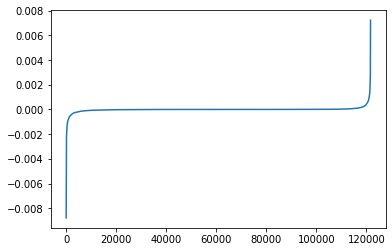

In [37]:
n_features = desc.shape[-1]

# D_0 : Domain
# D_1 : ?
# D_2 : Class
# D_3 : Order
# D_4 : Family
# D_5 : ?
# D_6 : ?

clf_logit.fit(desc, envs['empo_1'])
feature_idx = np.argsort(clf_logit.coef_[0])
plt.plot(range(n_features), sorted(clf_logit.coef_[0][feature_idx]))

species = pd.read_csv('bacterial_species.csv', index_col=0)
species.iloc[feature_idx][-60:]

# Dimensionality reduction

In [38]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200)
svd.fit(desc)

TruncatedSVD(n_components=200)

In [39]:
svd.explained_variance_ratio_.sum()

0.8926874973542692

In [40]:
desc_reduced = svd.transform(desc)

In [42]:
cross_validate_clf(clf_logit, desc_reduced, envs, 'empo_1')

/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

(array([0.93614487, 0.9304265 , 0.92756731, 0.93231649, 0.93040991]),
 array([0.93615199, 0.93044055, 0.92757101, 0.93232443, 0.93044675]))

In [43]:
cross_validate_clf(clf_logit, desc_reduced, envs, 'empo_2')

/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

(array([0.92637598, 0.92732904, 0.92566119, 0.93017159, 0.92683508]),
 array([0.92635491, 0.92723503, 0.92559064, 0.93005137, 0.92684775]))

In [44]:
cross_validate_clf(clf_logit, desc_reduced, envs, 'empo_3')

/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/toc/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

(array([0.89301882, 0.88062902, 0.87491065, 0.88131554, 0.88346044]),
 array([0.89121165, 0.87764107, 0.87244352, 0.87727898, 0.88197335]))

In [45]:
svd.components_.shape

(200, 121694)

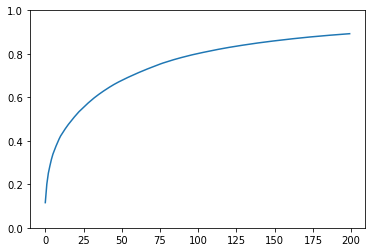

In [46]:
plt.ylim(0, 1)
plt.plot(svd.explained_variance_ratio_.cumsum())

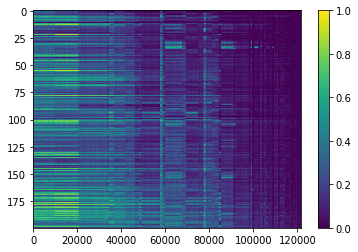

In [47]:
plt.imshow(svd.components_ > 1e-6, aspect='auto')
plt.colorbar()

In [48]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
selector = SelectKBest(mutual_info_classif, k=200)

In [49]:
n=100
selector.fit(desc[:n], envs['empo_1'][:n])

SelectKBest(k=200, score_func=<function mutual_info_classif at 0x7f2aef9f15a0>)